In [1]:
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add the project root to the Python path (so we can import microgrid_sim)
module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# --- Import Builders ---
from microgrid_sim.data import SyntheticDataBuilder, MesaDataBuilder, LiegeDataBuilder
from microgrid_sim.types import DataBuilder

# --- Import Components (for testing physics) ---
from microgrid_sim.components.generators import PVGenerator, WindTurbine, ReplayGenerator
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import BatteryRule

print("Imports OK")

Imports OK


## Helpers

In [3]:
total_hours = 24  # All plots are for a 24-hour period
sim_dt = 1
steps_per_hour = 60 // sim_dt
total_steps = total_hours * steps_per_hour
seed = 1

In [4]:
def _exog_list_to_dataframe(exog_list: list) -> pd.DataFrame:
    """
    Converts the complex exogenous list of dicts into a simple
    DataFrame for easy plotting.

    Input: [{'pv': {'irradiance_Wm2': 100}, 'wind': {'wind_speed_ms': 4.5}}, ...]
    Output: DataFrame with columns 'pv.irradiance_Wm2', 'wind.wind_speed_ms'
    """
    # Flatten the nested dictionaries
    flat_data = []
    for step_data in exog_list:
        row = {}
        for comp, data in step_data.items():
            for key, value in data.items():
                row[f"{comp}.{key}"] = value
        flat_data.append(row)

    df = pd.DataFrame(flat_data)

    # Create a time index in hours
    df['time_hours'] = np.arange(len(df)) * (sim_dt / 60.0)
    df = df.set_index('time_hours')
    return df

def plot_data(df: pd.DataFrame, columns: list, title: str,
              y_label: str, secondary_y: list = None,
              save_path: str = None):
    """
    Helper function to plot time-series data from a DataFrame.
    """
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(title)
    ax1.set_xlabel("Time (Hours)")
    ax1.set_ylabel(y_label)
    ax1.grid(True, which='major', axis='y')

    # Plot primary columns
    primary_cols = [c for c in columns if not secondary_y or c not in secondary_y]
    for col in primary_cols:
        if col in df.columns:
            ax1.plot(df.index, df[col], label=col)

    # Plot secondary columns on a twin axis
    if secondary_y:
        ax2 = ax1.twinx()
        ax2.set_ylabel(f"({secondary_y[0]})")
        for col in secondary_y:
            if col in df.columns:
                ax2.plot(df.index, df[col], label=col, linestyle='--', color='gray')

        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')
    else:
        ax1.legend(loc='best')

    ax1.set_xticks(np.arange(0, 25, 2)) # Ticks every 2 hours
    ax1.set_xlim(0, 24)

    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # Save the figure
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

print("Plotting helpers defined.")

Plotting helpers defined.


In [5]:
SAVE_DIR = "./Plots/01_component_testing"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Plots will be saved to {os.path.abspath(SAVE_DIR)}")

Plots will be saved to c:\Users\olanr\Downloads\course-proj\microgrid-control-sim\notebooks\Plots\01_component_testing


## Synthetic Data

In [6]:
print("\n--- Generating Synthetic Data ---")
synth_builder: DataBuilder = SyntheticDataBuilder(total_hours, sim_dt, seed)
synth_builder.add_pv("pv", peak_irr=1000)
synth_builder.add_wind("wind", mean_speed=7.0)
synth_builder.add_load("factory", base_kw=5.0, profile="factory")
synth_builder.add_load("house1", base_kw=1.5, profile="residential")
exog_list_synth = synth_builder.build_list()
df_synth = _exog_list_to_dataframe(exog_list_synth)
print("Synthetic data built.")


--- Generating Synthetic Data ---
Synthetic data built.


Plot saved to ./Plots/01_component_testing\synthetic_loads.png


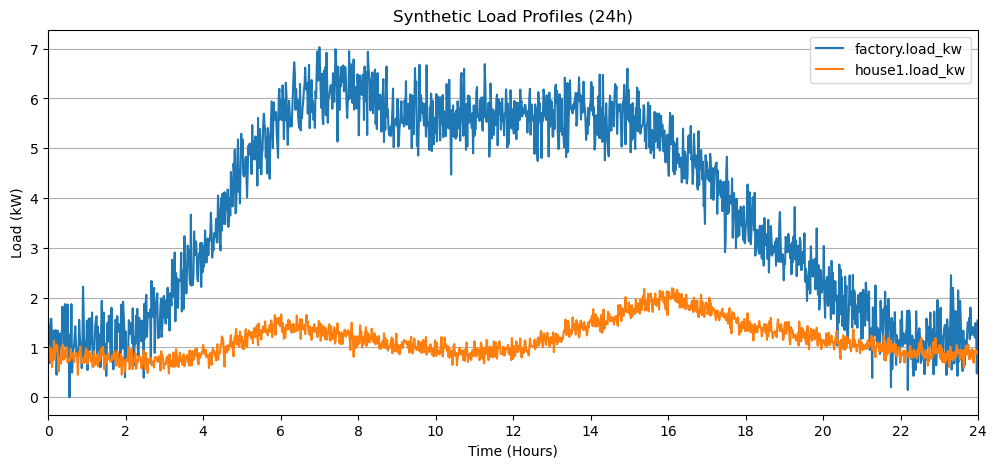

In [7]:
plot_data(
    df=df_synth,
    columns=["factory.load_kw", "house1.load_kw"],
    title="Synthetic Load Profiles (24h)",
    y_label="Load (kW)",
    save_path=os.path.join(SAVE_DIR, "synthetic_loads.png")
)

Plot saved to ./Plots/01_component_testing\synthetic_wind_vs_power.png


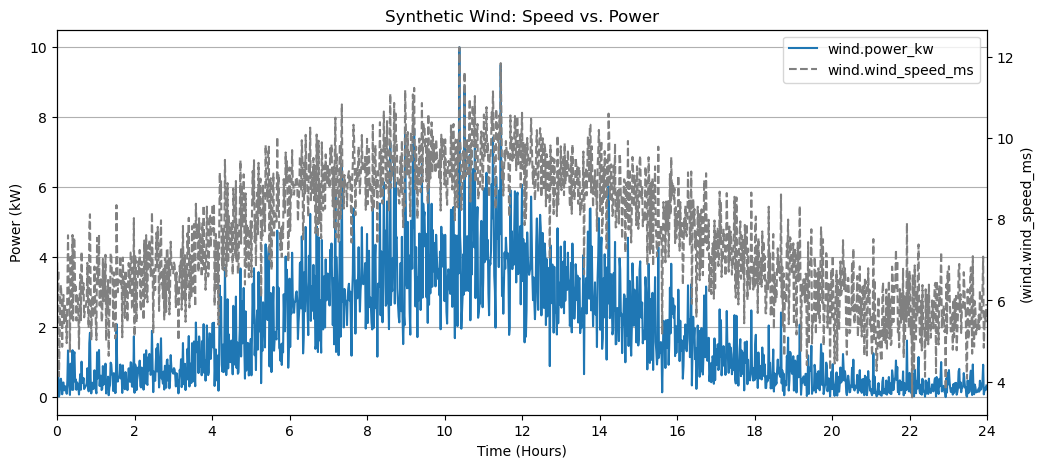

In [8]:
wind_comp = WindTurbine("wind_test", rated_kw=10.0, time_step_minutes=sim_dt)
wind_power = []
for exog in exog_list_synth:
    wind_comp.step(0, exogenous=exog.get('wind', {}))
    wind_power.append(wind_comp.get_power())
df_synth['wind.power_kw'] = wind_power

plot_data(
    df=df_synth,
    columns=["wind.power_kw"],
    title="Synthetic Wind: Speed vs. Power",
    y_label="Power (kW)",
    secondary_y=["wind.wind_speed_ms"],
    save_path=os.path.join(SAVE_DIR, "synthetic_wind_vs_power.png")
)

Plot saved to ./Plots/01_component_testing\synthetic_pv_vs_power.png


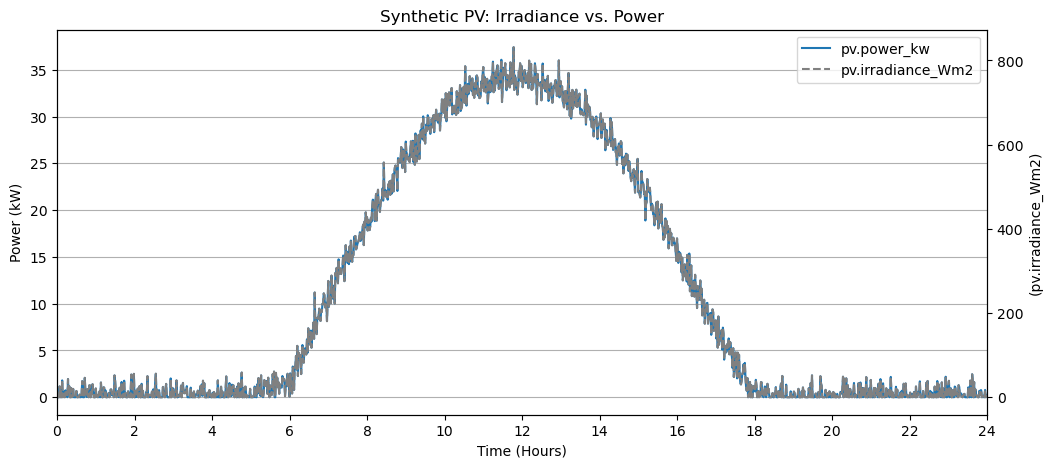

In [9]:
pv_comp = PVGenerator("pv_test", capacity_kw=50.0, time_step_minutes=sim_dt, derate=0.9)
pv_power = []
for exog in exog_list_synth:
    pv_comp.step(0, exogenous=exog.get('pv', {}))
    pv_power.append(pv_comp.get_power())
df_synth['pv.power_kw'] = pv_power

plot_data(
    df=df_synth,
    columns=["pv.power_kw"],
    title="Synthetic PV: Irradiance vs. Power",
    y_label="Power (kW)",
    secondary_y=["pv.irradiance_Wm2"],
    save_path=os.path.join(SAVE_DIR, "synthetic_pv_vs_power.png")
)

Plot saved to ./Plots/01_component_testing\synthetic_battery_test.png


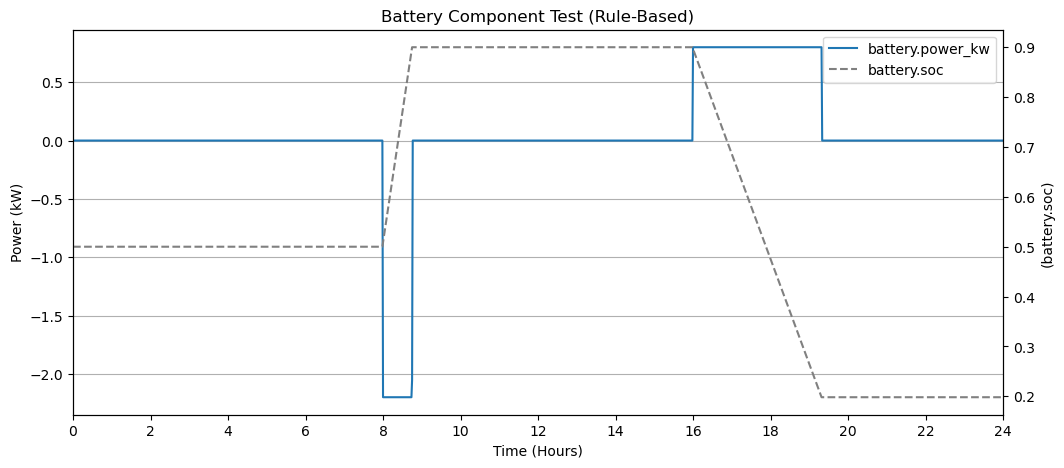

In [10]:
from microgrid_sim.control.rules import TimeSchedule


battery = BatteryStorage(
    "bat_test", capacity_kwh=4.0, time_step_minutes=sim_dt,
    initial_soc=0.5, max_charge_kw=50.0, max_discharge_kw=50.0
)
# Use the RuleBasedEMS to generate actions
rule = BatteryRule(
    name="bat_test",
    charge_kw=-2.2,
    discharge_kw=0.8,
    charge_schedule=TimeSchedule(8, 12),
    discharge_schedule=TimeSchedule(16, 20)
    )
ems = RuleBasedEMS(rules=[rule])

bat_power = []
bat_soc = []
for k in range(total_steps):
    hour = (k // steps_per_hour) % 24
    soc = battery.get_soc()

    action = ems.decide(hour, soc, {})
    battery.step(k, action=action.get("bat_test"))

    bat_power.append(battery.get_power())
    bat_soc.append(battery.get_soc())

df_synth['battery.power_kw'] = bat_power
df_synth['battery.soc'] = bat_soc

plot_data(
    df=df_synth,
    columns=["battery.power_kw"],
    title="Battery Component Test (Rule-Based)",
    y_label="Power (kW)",
    secondary_y=["battery.soc"],
    save_path=os.path.join(SAVE_DIR, "synthetic_battery_test.png")
)

## Data-Driven

Loading and concatenating all Mesa Del Sol CSVs...
Cleaning raw data. Clamping PV to [0.0, 50.0] kW.
Clamping Load to [0.0, 250.0] kW.
Resampling data...
Randomly selected start date: 2022-12-30T00:00:00.000000000
Note: Grid price data not included. Using synthetic prices.
Mesa data built.
Plot saved to ./Plots/01_component_testing\mesa_pv_power.png


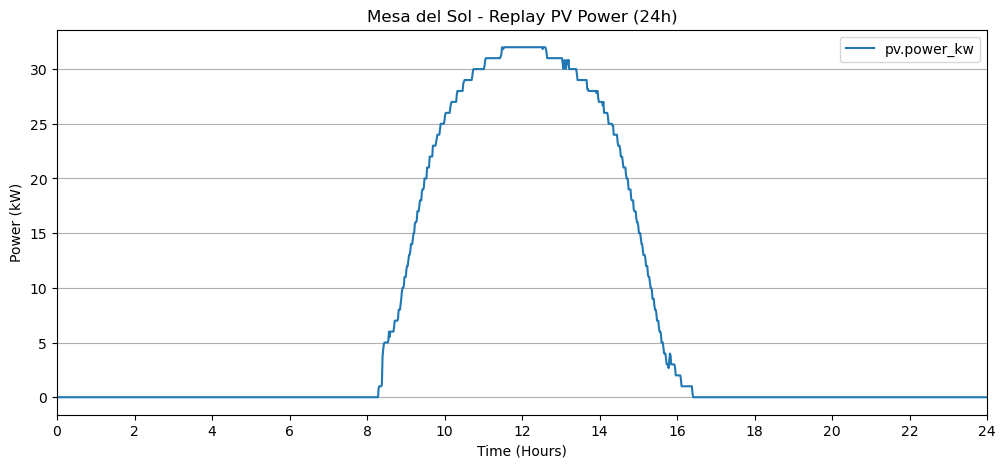

Plot saved to ./Plots/01_component_testing\mesa_load.png


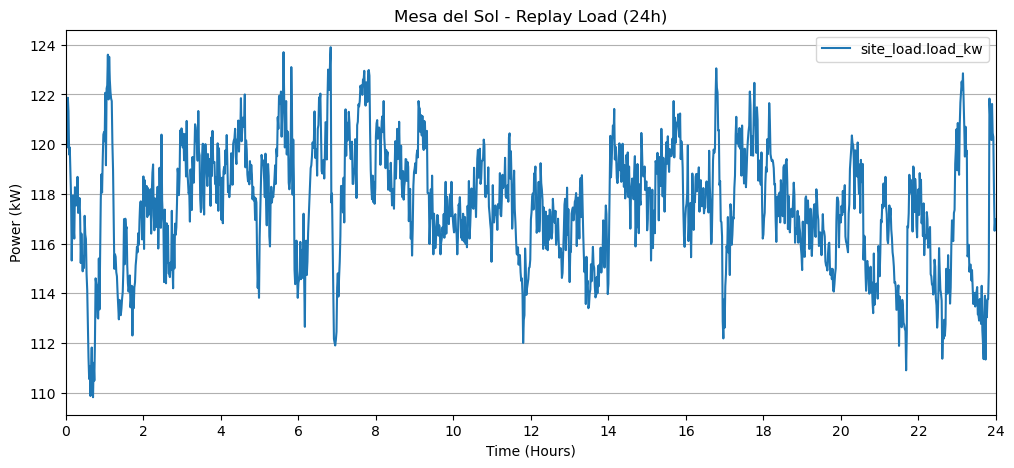

In [11]:
seed = 20
MESA_DATA_PATH = "../data/mesa"

mesa_builder: DataBuilder = MesaDataBuilder(
    csv_folder_path=MESA_DATA_PATH,
    total_hours=total_hours,
    sim_dt_minutes=sim_dt,
    seed=seed
)
exog_list_mesa = mesa_builder.build_list()
df_mesa = _exog_list_to_dataframe(exog_list_mesa)
print("Mesa data built.")

# --- 2.1 Plot PV Power ---
plot_data(
    df=df_mesa,
    columns=["pv.power_kw"],
    title="Mesa del Sol - Replay PV Power (24h)",
    y_label="Power (kW)",
    save_path=os.path.join(SAVE_DIR, "mesa_pv_power.png")
)

# --- 2.2 Plot Load ---
plot_data(
    df=df_mesa,
    columns=["site_load.load_kw"],
    title="Mesa del Sol - Replay Load (24h)",
    y_label="Power (kW)",
    save_path=os.path.join(SAVE_DIR, "mesa_load.png")
)

Loading and resampling Liège dataset...
Cleaning raw data. Clamping PV to [0.0, 0.8] kW.
Clamping Load to [0.0, 0.3] kW.
Randomly selected start date: 2019-06-14T00:00:00.000000000
Note: Grid price data not included. Using synthetic prices.
Liège data built.
Plot saved to ./Plots/01_component_testing\liege_pv_power.png


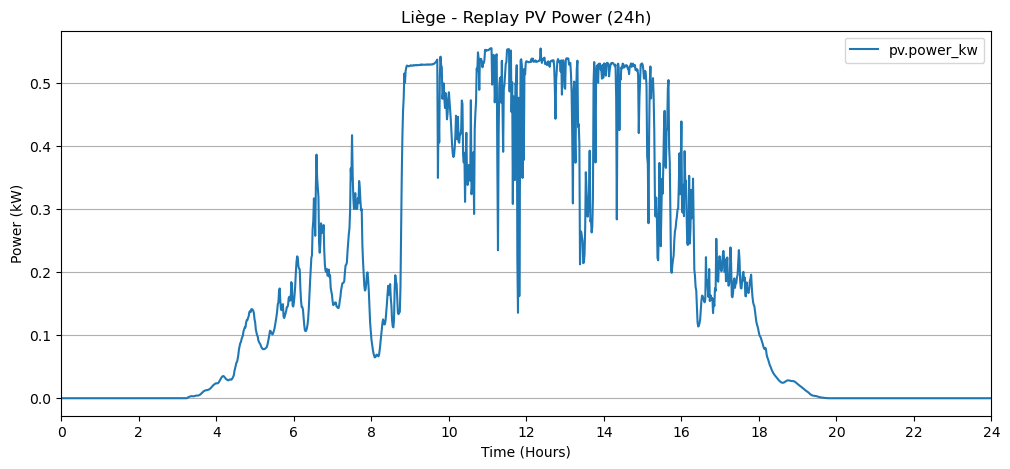

Plot saved to ./Plots/01_component_testing\liege_load.png


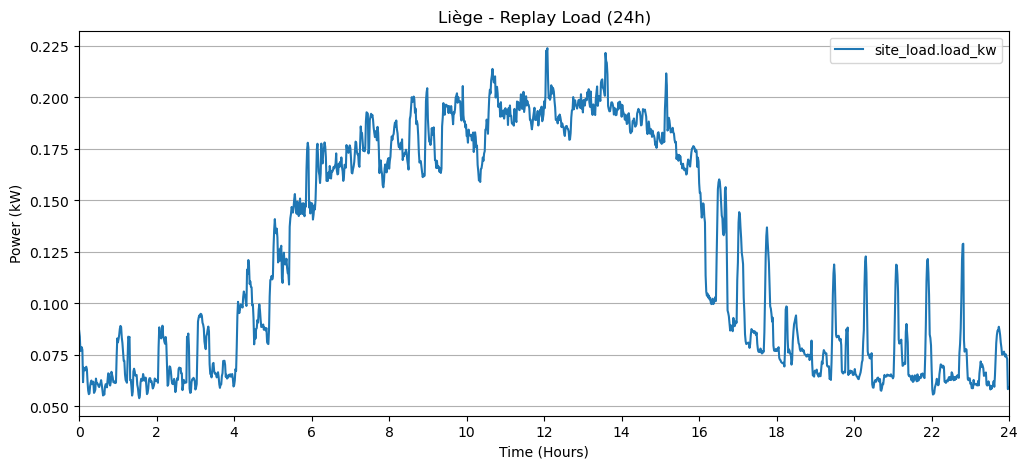

Plot saved to ./Plots/01_component_testing\liege_wind_speed.png


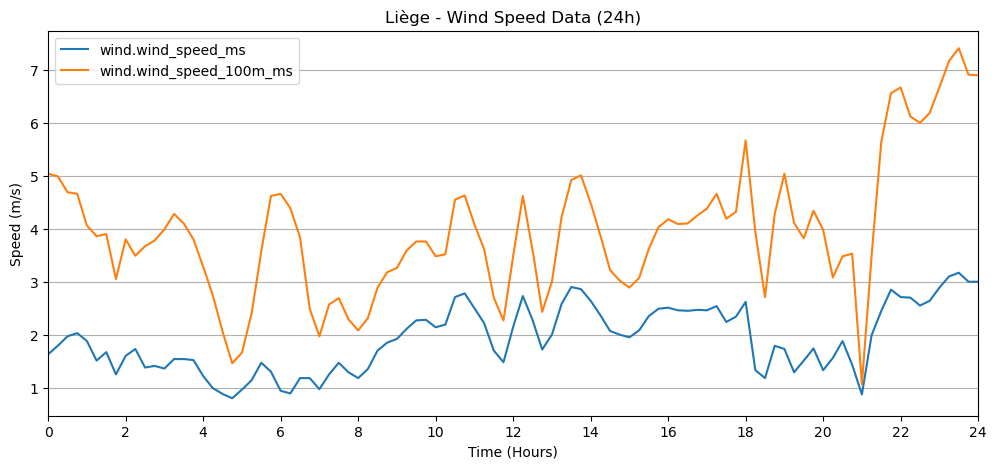

In [12]:
seed = 50

LIEGE_DATA_PATH = "../data/liege"

liege_builder: DataBuilder = LiegeDataBuilder(
    folder_path=LIEGE_DATA_PATH,
    total_hours=total_hours,
    sim_dt_minutes=sim_dt,
    seed=seed
)
exog_list_liege = liege_builder.build_list()
df_liege = _exog_list_to_dataframe(exog_list_liege)
print("Liège data built.")

# --- 3.1 Plot PV Power ---
plot_data(
    df=df_liege,
    columns=["pv.power_kw"],
    title="Liège - Replay PV Power (24h)",
    y_label="Power (kW)",
    save_path=os.path.join(SAVE_DIR, "liege_pv_power.png")
)

# --- 3.2 Plot Load ---
plot_data(
    df=df_liege,
    columns=["site_load.load_kw"],
    title="Liège - Replay Load (24h)",
    y_label="Power (kW)",
    save_path=os.path.join(SAVE_DIR, "liege_load.png")
)

# --- 3.3 Plot Wind Speeds ---
plot_data(
    df=df_liege,
    columns=["wind.wind_speed_ms", "wind.wind_speed_100m_ms"],
    title="Liège - Wind Speed Data (24h)",
    y_label="Speed (m/s)",
    save_path=os.path.join(SAVE_DIR, "liege_wind_speed.png")
)